## Imports

In [1]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.metrics import *
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class ImageFolderWithPaths(dset.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

train_dataset = ImageFolderWithPaths('../Dataset/train', transform=transform)
val_dataset = ImageFolderWithPaths('../Dataset/val', transform=transform)
test_dataset = ImageFolderWithPaths('../Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
IngreLabel = open('../VireoFood172/SplitAndIngreLabel/IngreLabel.txt', 'r').read().split('\n')[:-1]  # list of str
path_to_ingredients = dict()
for i in range(len(IngreLabel)):
    path_and_ingredients = IngreLabel[i].split()
    path, ingredients = path_and_ingredients[0], [0 if int(label) == -1 else int(label) for label in path_and_ingredients[1:]]
    path_to_ingredients[path] = np.array(ingredients)

In [7]:
def get_ingredients(path):
    split_path = path.split("/")
    key = '/' + '/'.join(split_path[3:])
    ingredients = path_to_ingredients[key]
    return ingredients

In [8]:
IngreList = open('../VireoFood172/SplitAndIngreLabel/IngredientList.txt', 'r').read().split('\n')[:-1]  # list of str
print(len(IngreList))

353


## Creating ResNext model

In [9]:
model = models.resnext50_32x4d(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
model.fc = nn.Sequential(nn.Linear(2048, 353), nn.Sigmoid())
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [20]:
model = gpu(model)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

## Training fully connected module

### Training the model

In [21]:
# Use threshold to define predicted labels and invoke sklearn's metrics with different averaging strategies.
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [22]:
def build_results(loss_history, accuracy_history, micro_f1_history, macro_f1_history, samples_f1_history):
    results = dict()
    results['loss_history'] = loss_history
    results['accuracy_history'] = accuracy_history
    results['micro_f1_history'] = micro_f1_history
    results['macro_f1_history'] = macro_f1_history
    results['samples_f1_history'] = samples_f1_history
    return results

In [23]:
def train_model(model, optimizer, epochs=1):
    train_loss_history, train_accuracy_history = [], []
    train_micro_f1_history, train_macro_f1_history, train_samples_f1_history = [], [], []
    val_loss_history, val_accuracy_history = [], []
    val_micro_f1_history, val_macro_f1_history, val_samples_f1_history = [], [], []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        i = 0
        model_result = []
        targets = []
        for x, food_labels, paths in batches:
            if i % 100 == 0:
                print("Iteration {}".format(i))
            y = np.array([get_ingredients(path) for path in paths])
            x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
            scores = model(x)
            loss = criterion(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.data.item()
            num_correct += get_num_correct(scores, y)
            num_samples += x.size(0)
            i += 1
            
            model_result.extend(scores.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Epoch:{:2d} Training: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(epoch + 1, micro_f1, macro_f1, samples_f1))
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        train_micro_f1_history.append(micro_f1)
        train_macro_f1_history.append(macro_f1)
        train_samples_f1_history.append(samples_f1)
        print('Epoch: {} Training Loss: {:.8f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, 
                       val_micro_f1_history, val_macro_f1_history, val_samples_f1_history,
                       epoch)
    train_results = build_results(train_loss_history, train_accuracy_history,
                                  train_micro_f1_history, train_macro_f1_history, train_samples_f1_history)
    val_results = build_results(val_loss_history, val_accuracy_history,
                                val_micro_f1_history, val_macro_f1_history, val_samples_f1_history)
    results = dict()
    results['train'] = train_results
    results['val'] = val_results
    return results

def check_accuracy(model, val_loss_history, val_accuracy_history, 
                   val_micro_f1_history, val_macro_f1_history, val_samples_f1_history,
                   epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        model_result = []
        targets = []
        for x, food_labels, paths in batches:
            y = np.array([get_ingredients(path) for path in paths])
            x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
            scores = model(x)
            loss = criterion(scores, y) 
            total_loss += loss.data.item()
            num_correct += get_num_correct(scores, y)
            num_samples += x.size(0)
            
            model_result.extend(scores.cpu().numpy())
            targets.extend(y.cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Epoch:{:2d} Validation: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(epoch + 1,
                                          result['micro/f1'],
                                          result['macro/f1'],
                                          result['samples/f1']))
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    val_micro_f1_history.append(micro_f1)
    val_macro_f1_history.append(macro_f1)
    val_samples_f1_history.append(samples_f1)
    print('Epoch: {} Validation Loss: {:.8f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))

def get_num_correct(scores, y):
    scores[scores >= 0.5] = 1
    scores[scores < 0.5] = 0
    num_correct = (scores == y).all(dim=1).sum().item()
    return num_correct

In [24]:
%%time
num_epochs = 5
results = train_model(gpu(model), optimizer, epochs=num_epochs)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 Training: Micro F1: 0.869 Macro F1: 0.652 Samples F1: 0.865
Epoch: 1 Training Loss: 0.00009561 Got 35480 / 66071 correct. Acc: 53.70%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 1 Validation: Micro F1: 0.724 Macro F1: 0.520 Samples F1: 0.705
Epoch: 1 Validation Loss: 0.00024622 Got 3613 / 11016 correct 32.80%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 Training: Micro F1: 0.903 Macro F1: 0.724 Samples F1: 0.902
Epoch: 2 Training Loss: 0.00007059 Got 41292 / 66071 correct. Acc: 62.50%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 2 Validation: Micro F1: 0.730 Macro F1: 0.527 Samples F1: 0.716
Epoch: 2 Validation Loss: 0.00026356 Got 3671 / 11016 correct 33.32%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 Training: Micro F1: 0.922 Macro F1: 0.781 Samples F1: 0.921
Epoch: 3 Training Loss: 0.00005764 Got 44757 / 66071 correct. Acc: 67.74%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 3 Validation: Micro F1: 0.729 Macro F1: 0.534 Samples F1: 0.712
Epoch: 3 Validation Loss: 0.00027363 Got 3681 / 11016 correct 33.42%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 Training: Micro F1: 0.936 Macro F1: 0.821 Samples F1: 0.936
Epoch: 4 Training Loss: 0.00004754 Got 47671 / 66071 correct. Acc: 72.15%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 4 Validation: Micro F1: 0.721 Macro F1: 0.528 Samples F1: 0.705
Epoch: 4 Validation Loss: 0.00029789 Got 3612 / 11016 correct 32.79%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 Training: Micro F1: 0.946 Macro F1: 0.857 Samples F1: 0.945
Epoch: 5 Training Loss: 0.00004074 Got 49829 / 66071 correct. Acc: 75.42%


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Epoch: 5 Validation: Micro F1: 0.719 Macro F1: 0.532 Samples F1: 0.703
Epoch: 5 Validation Loss: 0.00031779 Got 3646 / 11016 correct 33.10%
CPU times: user 1h 6min 33s, sys: 19min 21s, total: 1h 25min 54s
Wall time: 1h 28min 52s


In [25]:
# Save the model.
PATH = "../saved_models/ingredients/resnext/resnext.dat"
torch.save(model, PATH)
torch.save(results, '../saved_models/ingredients/resnext/resnext-results-2.pt')

## Evaluation

In [17]:
# Load the model.
PATH = "../saved_models/ingredients/resnext/resnext.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
results1 = torch.load('../saved_models/ingredients/resnext/resnext-results-1.pt')
results2 = torch.load('../saved_models/ingredients/resnext/resnext-results-2.pt')

In [26]:
results1 = torch.load('../saved_models/ingredients/resnext/resnext-results-1.pt')
results2 = torch.load('../saved_models/ingredients/resnext/resnext-results-2.pt')

train_results1, val_results1 = results1['train'], results1['val']
train_results2, val_results2 = results2['train'], results2['val']

LOSS1, ACC1, LOSS_V1, ACC_V1 = (train_results1['loss_history'], train_results1['accuracy_history'], 
                                val_results1['loss_history'], val_results1['accuracy_history'])
LOSS2, ACC2, LOSS_V2, ACC_V2 = (train_results2['loss_history'], train_results2['accuracy_history'], 
                                val_results2['loss_history'], val_results2['accuracy_history'])

LOSS = LOSS1 + LOSS2
ACC = ACC1 + ACC2
LOSS_V = LOSS_V1 + LOSS_V2
ACC_V = ACC_V1 + ACC_V2

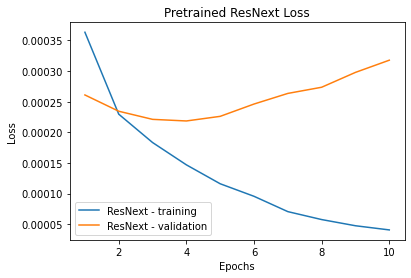

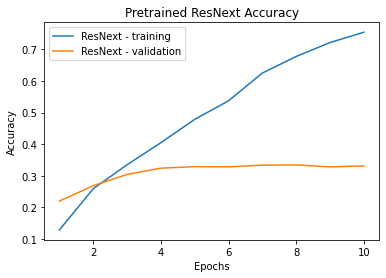

In [27]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('ResNext', LOSS, ACC, LOSS_V, ACC_V)

In [28]:
# Evaluation: Compute Accuracy and Micro F1, Macro F1, Samples F1 scores

def compute_accuracy(model):
    num_correct, num_samples, total_loss = 0, 0, 0
    with torch.no_grad():
        model.eval()
        model_result = []
        targets = []
        for x, food_labels, paths in test_dataloader:
            y = np.array([get_ingredients(path) for path in paths])
            x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
            scores = model(x)
            loss = criterion(scores, y) 
            total_loss += loss.data.item()
            num_correct += get_num_correct(scores, y)
            num_samples += x.size(0)
            
            model_result.extend(scores.cpu().numpy())
            targets.extend(y.cpu().numpy())
        result = calculate_metrics(np.array(model_result), np.array(targets))
        micro_f1, macro_f1, samples_f1 = result['micro/f1'], result['macro/f1'], result['samples/f1']
        print("Testing: "
              "Micro F1: {:.3f} "
              "Macro F1: {:.3f} "
              "Samples F1: {:.3f}".format(result['micro/f1'],
                                          result['macro/f1'],
                                          result['samples/f1']))
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples

    print('Accuracy of the network on the all test images: %.2f%%' % (
        100 * num_correct / num_samples))

compute_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _

Testing: Micro F1: 0.715 Macro F1: 0.536 Samples F1: 0.697
Accuracy of the network on the all test images: 32.70%


## Precision + Recall Statistics

We compute aggregate precision-recall stats as well as precision-recall stats on a per-ingredient basis.
Store the predictions made by the model in y_score and the correct labels in y_test for all the testing examples.

In [29]:
y_score = []
y_test = []
criterion = nn.BCELoss()
with torch.no_grad():
    model.eval()
    for x, food_labels, paths in test_dataloader:
        y = np.array([get_ingredients(path) for path in paths])
        x, y = gpu(x), gpu(torch.from_numpy(y)).to(torch.float32)
        scores = model(x)
        y_score.extend(scores.cpu().numpy())
        y_test.extend(y.cpu().numpy())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
y_score = np.array(y_score)
y_test = np.array(y_test)

Store the thresholded predictions made by the model in y_pred (using a default threshold of 0.5 for each ingredient category)

In [31]:
y_pred = np.array(y_score > 0.5, dtype=float)

### Compute Precision/Recall for each Ingredient Manually

In [32]:
# Manual Precision/Recall Calculations:
from collections import defaultdict

num_classes = 353
pr_stats = dict()
for j in range(num_classes):
    pr_stats[j] = defaultdict(int)
for (y_test_i, y_pred_i) in zip(y_test, y_pred):
    for j in range(num_classes):
        if y_test_i[j] == 0 and y_pred_i[j] == 0:
            pr_stats[j]["TN"] += 1
        elif y_test_i[j] == 1 and y_pred_i[j] == 1:
            pr_stats[j]["TP"] += 1
        elif y_test_i[j] == 1 and y_pred_i[j] == 0:
            pr_stats[j]["FN"] += 1
        elif y_test_i[j] == 0 and y_pred_i[j] == 1:
            pr_stats[j]["FP"] += 1

In [33]:
precision = dict()
recall = dict()
dash = '-' * 75
print("Precision-Recall Statistics for each Ingredient")
print(dash)
print('{:<50s}{:^10s}{:^15s}'.format("Ingredient", "Precision", "Recall"))
print(dash)
for j in range(num_classes):
    if (pr_stats[j]["TP"] + pr_stats[j]["FP"]) == 0:
        precision[j] = 0
    else:
        precision[j] = pr_stats[j]["TP"] / (pr_stats[j]["TP"] + pr_stats[j]["FP"])
        
    if (pr_stats[j]["TP"] + pr_stats[j]["FN"]) == 0:
        recall[j] = 0
    else:
        recall[j] = pr_stats[j]["TP"] / (pr_stats[j]["TP"] + pr_stats[j]["FN"])
    print('{:<50s}{:^10.2f}{:^15.2f}'.format(IngreList[j], precision[j], recall[j]))  

Precision-Recall Statistics for each Ingredient
---------------------------------------------------------------------------
Ingredient                                        Precision     Recall     
---------------------------------------------------------------------------
Minced green onion                                   0.81        0.69      
chiffonade of green onion                            0.70        0.67      
Seared green onion                                   0.63        0.20      
White onion                                          0.76        0.83      
Brunoise diced ham                                   0.77        0.72      
Julienned ham                                        0.36        0.50      
Ham                                                  0.18        0.25      
Sliced ham                                           0.09        0.35      
Brunoise diced carrot                                0.78        0.61      
Sliced carrot                           

### Sklearn Classification Report

In [34]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=IngreList))


Accuracy: 0.33

Micro Precision: 0.79
Micro Recall: 0.66
Micro F1-score: 0.72



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.65
Macro Recall: 0.50
Macro F1-score: 0.54



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Precision: 0.79
Weighted Recall: 0.66
Weighted F1-score: 0.71

Classification Report



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                            precision    recall  f1-score   support

                        Minced green onion       0.81      0.69      0.74      6698
                 chiffonade of green onion       0.70      0.67      0.69       666
                        Seared green onion       0.63      0.20      0.30       731
                               White onion       0.76      0.83      0.79       144
                        Brunoise diced ham       0.77      0.72      0.74       435
                             Julienned ham       0.36      0.50      0.42        10
                                       Ham       0.18      0.25      0.21        24
                                Sliced ham       0.09      0.35      0.14        46
                     Brunoise diced carrot       0.78      0.61      0.68       868
                             Sliced carrot       0.56      0.51      0.53       365
                           Batonnet carrot       0.40      0.10      0.16  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Precision-Recall Curves (to investigate the effect of different thresholds)

Note: this code was modified from https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 353
thresholds = dict()
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.76


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.76')

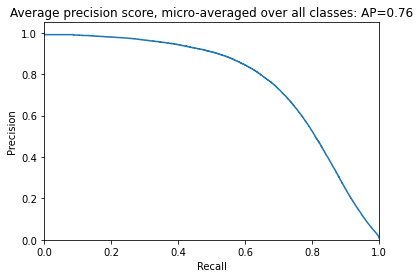

In [36]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

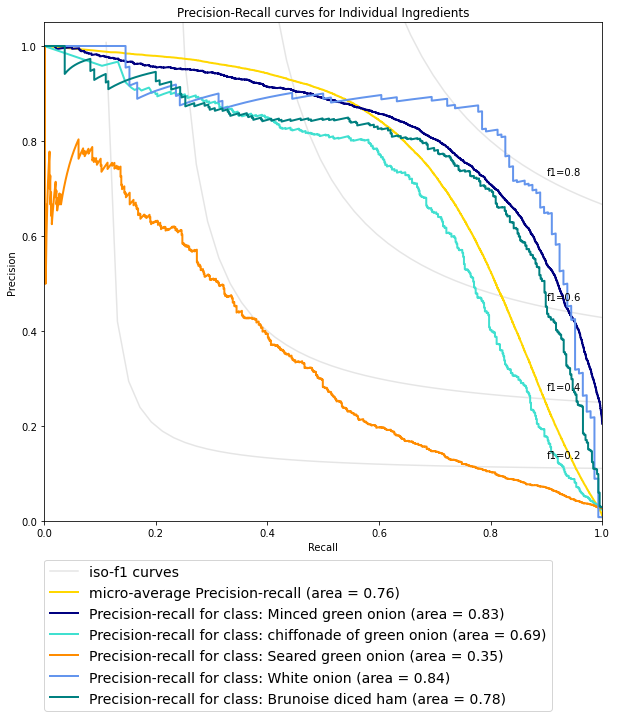

In [37]:
from itertools import cycle
# setup plot details
num_classes = 5
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 11))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class: {0} (area = {1:0.2f})'
                  ''.format(IngreList[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curves for Individual Ingredients')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

## Investigate one of the ingredients with 0 Precision and Recall (e.g.: bacon)

In [39]:
bacon_index = 23
bacon_pred, bacon_test = 0, 0
for (y_test_i, y_pred_i) in zip(y_test, y_pred):
    if y_test_i[bacon_index] == 1:
        bacon_test += 1
    if y_pred_i[bacon_index] == 1:
        bacon_pred += 1
print("Number of testing examples with bacon as an ingredient: {}".format(bacon_test))
print("Number of testing examples where the model predicted bacon as an ingredient: {}".format(bacon_pred))

Number of testing examples with bacon as an ingredient: 7
Number of testing examples where the model predicted bacon as an ingredient: 4
